In [1]:
LIVENOTEBOOK = False
import cv2
cv2.__version__



'3.3.0'

In [2]:
LIVENOTEBOOK = True

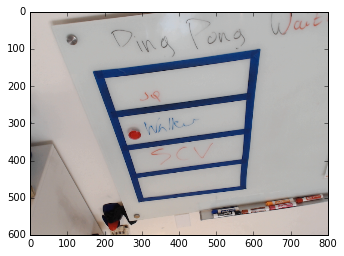

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim 
def imshow(img):  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
if LIVENOTEBOOK:
    %matplotlib inline
    img = cv2.imread("../reference/frame17978.png")
    # test plotting
    imshow(img)

In [4]:
def tightbluemask(image, clean=True):
    """Returns a mask (grayscale image) which is >0 in the area of the blue grid."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    threshold  = np.array([[103,95,30],[120,240,125]])
    mask = cv2.inRange(hsv, threshold[0,:], threshold[1,:])

    if clean:
        # close gaps
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)) 
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        # remove speckles
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask



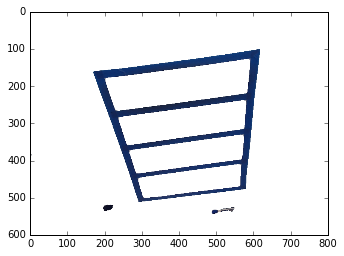

In [5]:
# step 1, extract the right kind of blue
if LIVENOTEBOOK:
    image = img
    mask = tightbluemask(img)
    bluewhite = img.copy()
    bluewhite[mask==0,:] = (255,255,255)
    imshow(bluewhite)

Found 5 outer contours


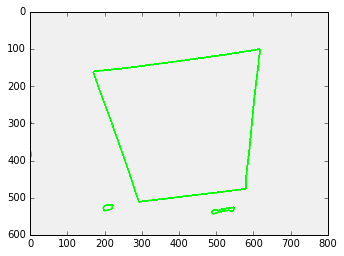

In [6]:
# step 2 :extract raw contours
if LIVENOTEBOOK:
    dst = np.zeros(image.shape, np.uint8)
    dst[:]=(240,240,240)
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    print("Found %d outer contours" % len(cnts))
    cv2.drawContours(dst, cnts, -1, (0,255,0), 3)
    plt.imshow(dst)

Found shape with sides: 15
Found shape with sides: 17
Found shape with sides: 10
Found shape with sides: 6
Found shape with sides: 4
-- Found: 445 x 409


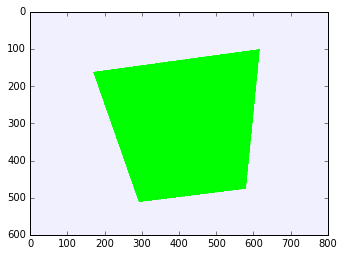

In [7]:
# simplify contours, find one that is a rectangle
def find_outer_rect(cnts, img=None):
    """Find the one large rectangle in a list of contours, returns an approximated contour 
    and optionally an image of the contour
    
    If an optional image is passed, this routine will return a filled 3-channel image of the found contour.
    In channel 0, the area inside the outer rect is 0, 255 elsewhere."""
    
    if not img is None:
        dst = np.zeros(img.shape, np.uint8)
        dst[:] = (255,240,240)
    else:
        dst = None
    for c in cnts:
        peri = 0.01 * cv2.arcLength(c, True)  # approximate such that points are never > 0.01*perimeter away
        approx = cv2.approxPolyDP(c, peri, True)
        print ("Found shape with sides: %d" % len(approx))
        if len(approx) == 4:
                approx = np.reshape(approx,[4,2]) # drop 2nd dimension 
                xsize = approx[:,0].max() - approx[:,0].min()
                ysize = approx[:,1].max() - approx[:,1].min()
                if xsize > 300 and ysize > 150:
                    print ("-- Found: %d x %d" % (xsize, ysize))
                    if not img is None:
                        cv2.drawContours(dst, [approx], -1, (0,255,0), cv2.FILLED)
                    break
                else:
                    print ("-- Rejected rectangle: %d x %d" % (xsize, ysize))
    else:
        raise ValueError("No outer rectangle found")
    return approx, dst

# step 3: get outer rectangle
if LIVENOTEBOOK:
    (outerRectangle, filledMask) = find_outer_rect(cnts, img)
    imshow(filledMask)

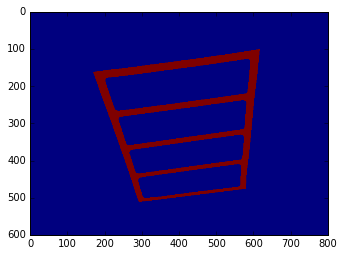

In [8]:
# step 4: remove area outside of outer rectangle from mask (ie set to 0)
if LIVENOTEBOOK:
    mask[filledMask[:,:,0]>0]=0
    plt.imshow(mask)


In [9]:
def find_inner_rectangles(img):
    # find inner rectangles
    _, cnts, hier = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = []
    for i in range(len(cnts)):
        contour = cnts[i]
        _,_,w,h = cv2.boundingRect(contour)
        if w>100 and h>50:
            contours.append(contour)
        else:
            hier[0, i, -1] = -2 # mark for deletion

    hier = np.delete(hier, np.where(hier[0,:,-1] == -2)[0], 1)

    assert len(contours) == 5, "there should be five contours: found %d" % len(contours)
    assert hier[0,0,-1] == -1, "first contour should be the outer one, ie it has no parent"
    assert np.all(hier[0,1:5,-1] == 0), "all other contours should have the first contour as their parent"
    hier = np.delete(hier, 0, 1) # remove parent from list of hier
    contours = contours[1:] # remove parent from contours
    contours.sort(key=lambda a: a[:,0,1].min()) # sort contours by minimum y value (top down)
    return contours, hier

# step 5: find inner rectangles
if LIVENOTEBOOK:
    contours, hier = find_inner_rectangles(mask)
    assert len(contours) == 4, "Expected four inner rectangles, found %d " % len(contours)


In [10]:
hier

array([[[ 2, -1, -1,  0],
        [ 3,  1, -1,  0],
        [ 4,  2, -1,  0],
        [-1,  3, -1,  0]]], dtype=int32)

In [11]:
# http://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts, wh):
    rect = order_points(pts)
    
    if not wh:
        (tl, tr, br, bl) = rect

        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        wh = (maxWidth, maxHeight)
 
    dst = np.array([
        [0, 0],
        [wh[0] - 1, 0],
        [wh[0] - 1, wh[1] - 1],
        [0, wh[1] - 1]], dtype = "float32")
 
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, wh)
 
    return warped, wh

In [12]:
class Box(object):
    "data class for image of the four squares (boxes) on our white board"
    def __init__(self, **kwargs):
            self.__dict__.update(kwargs)
    def __str__(self):
        return "Box< %r >" % self.__dict__

Found shape with sides: 4
Found shape with sides: 4
Found shape with sides: 4
Found shape with sides: 4


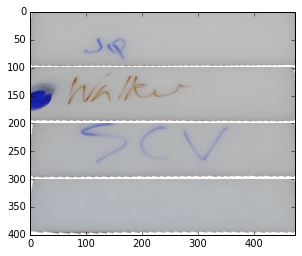

In [22]:
# TODO this all assumes the first box is the largest one, which we don't test or ensure

def get_inner_rect_contents(contours, image):
    """for each inner rectangle in 'contours', extract a standard size rectange with 
    the (masked) contents of this rectangle from 'image'.  Returns a list of cropped images. """

    boxes = []
    wh = (475, 100) # scaled from what we have
    kernel =  np.ones((5,5), np.uint8)
    for contour in contours:
        # compute mask from contour by filling
        mask = np.zeros(image.shape[:2], np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        # make mask about 5px smaller on all sides
        mask = cv2.erode(mask, kernel)
        peri = cv2.arcLength(contour, True)  # approximate such that points are never > 0.05*perimeter away
        approx = cv2.approxPolyDP(contour, 0.05 * peri, True)
        # create white box and copy image in where mask is true
        box = Box(img=np.zeros_like(image), perimeter=peri, contour=contour)  # TODO enlarge image here
        box.img.fill(255)
        box.img[mask == 255] = image[mask == 255] 
        # find simpler contour
        print ("Found shape with sides: %d" % len(approx))        
        box.img, wh = four_point_transform(box.img, approx[:,0,:], wh)        
        boxes.append(box)
    return boxes
    
# step 6: get contents of inner rectangles (boxes)
if LIVENOTEBOOK:
    boxes = get_inner_rect_contents(contours, img)
    plt.imshow(np.concatenate([x.img for x in boxes]))    
    

In [23]:
def get_contents(imagepath):
    img = cv2.imread(imagepath)

    # step 1, extract the right kind of blue
    # image = img
    mask = tightbluemask(img)
    bluewhite = img.copy()
    bluewhite[mask==0,:] = (255,255,255)
    
    # step 2 :extract raw contours
    dst = np.zeros(img.shape, np.uint8)
    dst[:]=(240,240,240)
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    print("Found %d outer contours" % len(cnts))
    cv2.drawContours(dst, cnts, -1, (0,255,0), 3)
    
    # step 3: get outer rectangle
    (outerRectangle, filledMask) = find_outer_rect(cnts, img)
    
    # step 4: remove area outside of outer rectangle from mask (ie set to 0)
    mask[filledMask[:,:,0]>0]=0
    
    # step 5: find inner rectangles
    contours, hier = find_inner_rectangles(mask)
    assert len(contours) == 4, "Expected four inner rectangles, found %d " % len(contours)

    # step 6: get contents of inner rectangles (boxes)
    boxes = get_inner_rect_contents(contours, img)
    return boxes
    


# Full or empty?
Given code that can extract the contents of the inner rectangles (boxes), we can determine whether the 
contents have changed _and_ whether the box is empty or not.


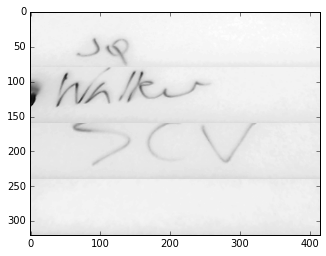

In [24]:
# we have this nice code for shrinking contours but it not necessary anymore...
h,w = boxes[0].img.shape[:2]
for box in boxes:
    box.template = cv2.cvtColor(box.img[10:h-10, 30:w-30], cv2.COLOR_BGR2GRAY)
    
plt.imshow(np.concatenate([x.template for x in boxes]), cmap="gray")   

In [25]:
[ x.template.shape for x in boxes ]

[(80, 415), (80, 415), (80, 415), (80, 415)]

[32706.0]
[32706.0]
[32706.0]
[32706.0]


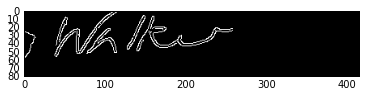

In [27]:
tt = boxes[1].template
tt = cv2.Canny(tt,10,200)
cnts = cv2.findContours(box.template.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(tt, cmap="gray")

(46, 50) (46, 50)


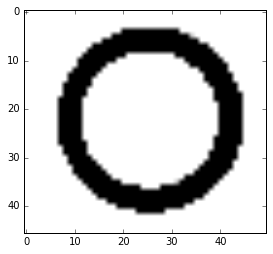

In [52]:
namefound = cv2.cvtColor(cv2.imread('./namefound50.png'), cv2.COLOR_BGR2GRAY)
namemissing = cv2.cvtColor(cv2.imread('./namemissing50.png'), cv2.COLOR_BGR2GRAY)
print(namefound.shape, namemissing.shape)
plt.imshow(namemissing, cmap="gray")

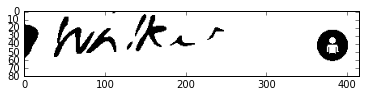

In [53]:
# using Otsu binarization, assumes histo with two peaks (white-black)
tt = boxes[1].template
blur = cv2.GaussianBlur(tt, (5,5), 0)
otsu, tt = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
tt[20:66,-60:-10] = namefound
plt.imshow(tt, cmap="gray")

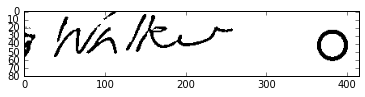

In [54]:
# using adaptive thresholding
tt = boxes[1].template
blur = cv2.GaussianBlur(tt, (5,5), 0)
tt = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
tt[20:66,-60:-10] = namemissing
plt.imshow(tt, cmap="gray")

[True, True, True, False]


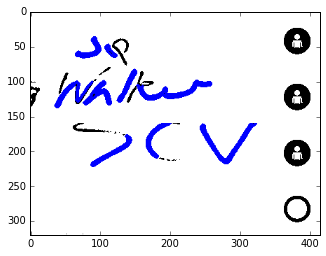

In [73]:
namefound = cv2.cvtColor(cv2.imread('./namefound50.png'), cv2.COLOR_BGR2GRAY)
namemissing = cv2.cvtColor(cv2.imread('./namemissing50.png'), cv2.COLOR_BGR2GRAY)

for b in boxes:
    #image = cv2.Canny(b.template,10,200)
    blur = cv2.GaussianBlur(b.template, (5,5), 0)
    bg = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    dst = np.dstack([bg, bg, bg])
    image = cv2.Canny(bg, 10, 200)
    cnts = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    cnts = [ c for c in cnts if cv2.contourArea(c) >= 20 ]
    b.hascontent = len(cnts) > 1
    if b.hascontent:
        color = (255,0,0)
        icon = namefound
    else: 
        color = (0,0,255)
        icon = namemissing
    cv2.drawContours(dst, cnts, -1, color, 3)
    dst[20:66,-60:-10,:] = np.dstack([icon, icon, icon])
    b.contentdetection = dst

if LIVENOTEBOOK:
    print([b.hascontent for b in boxes])
    imshow(np.concatenate([b.contentdetection for b in boxes]))
    

In [ ]:
print ([cv2.contourArea(x) for x in cnts])